In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('seaborn-v0_8-dark-palette')

#### Updates:

<ul>
    <b>In this cycle we add:</b>
    <li>Save and load model functions</li>
    <li>Added lr_scheduler using</li>
    <li>Added early stopping</li>
</ul>

#### Define device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Create Dataset

In [3]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)
        
    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = np.array(Image.open(path_img))
        # coords = np.array(self.dict_coords[name_file])
        coords = torch.tensor(self.dict_coords[name_file], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, coords

In [4]:
# transform data
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5,))
    ]
)

In [5]:
# create datasets
# note: you need to run scripts from dataloader part
dataset = DatasetReg(os.path.join(os.getcwd(), 'dataset'), transform=transform)

coord = tensor([42., 31.])


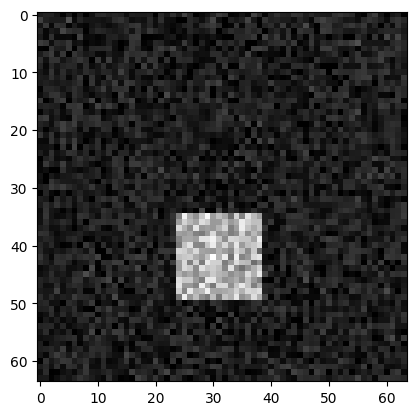

In [6]:
# plot some info
img, coord = dataset[2512]

print(f'coord = {coord}')
plt.imshow(img.numpy()[0], cmap='gray')

In [7]:
# split data
train_data, val_data, test_data = random_split(dataset, [0.7, 0.1, 0.2])

In [8]:
# split data on batches
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

#### Create model

In [9]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [10]:
model = MyModel(64 * 64, 2).to(device)

In [11]:
# check
input = torch.rand([16, 64 * 64], dtype=torch.float32).to(device)

out = model(input)
out.shape

torch.Size([16, 2])

#### Setup loss, optimizer and lr_scheduler

In [12]:
# setup loss GD optimizer
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# lr_scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=1e-1,
    threshold=1e-4,
    # patience=5,
    threshold_mode='rel',
    cooldown=0,
    min_lr=0,
    eps=1e-08
)

#### Define Early Stopping class(note: we could do it easier)

In [13]:
class EarlyStopping:
    def __init__(self, mode='min', patience=10, threshold=1e-5, threshold_mode='rel'):
        if mode not in {'min', 'max'}:
            raise ValueError('Param mode can be only mах and min.')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError('Param threshold_mode can be only rel and abs.')
        if threshold > 1.0:
            raise ValueError('Param threshold must be less than 1.0.')
        if not isinstance(threshold, float):
            raise TypeError('Param threshold must be float и and less than 1,0.')
        if not isinstance(patience, int):
            raise TypeError('Param patience must be int.')

        self.mode = mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count = 0
        self.best = None

    def __call__(self, tracked_parameter):
        current = float(tracked_parameter)
        if self.best is None:
            self.best = current
            return False

        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
        else:
            self.count += 1

        if self.count >= self.patience:
            self.count = 0
            return True
        return False
    
    def changed_better(self, current, best):
        if self.mode == 'min' and self.threshold_mode == 'rel':
            return current < best - best * self.threshold

        elif self.mode == 'min' and self.threshold == 'abs':
            return current < best - self.threshold

        elif self.mode == 'max' and self.threshold_mode == 'rel':
            return current > best + best * self.threshold

        else: # mode == 'max' and threshold == 'abs'
            return current > best + self.threshold

#### Setup checkpoints

In [14]:
EPOCHS = 5
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None
str_info = """
    class MyModel(nn.Module):
        def __init__(self, input, output):
            super().__init__()
            self.layer_1 = nn.Linear(input, 128)
            self.layer_2 = nn.Linear(128, output)
            self.act = nn.ReLU()
    
        def forward(self, x):
            x = self.layer_1(x)
            x = self.act(x)
            out = self.layer_2(x)
            return out
"""

#### Extend our traning cycle!

In [15]:
count = 0

# training cycle
for epoch in range(EPOCHS):

    # train model
    model.train() # setup train mode
    # we will save our loss
    running_train_loss = []
    # add metric(accuracy)
    true_answer = 0
    # add progress bar
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # data
        # (batch_size, 1, 64, 64) -> (batch_size, 64 * 64)
        x = x.reshape(-1, 64 * 64).to(device)
        targets = targets.to(device)
        
        # forward pass + loss calc
        pred = model(x)
        loss = loss_model(pred, targets)

        # backward pass
        opt.zero_grad()
        loss.backward()
        # optimization step
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
        
        # add description to progress bar
        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}')

    # calc metric
    running_train_accuracy = true_answer / len(train_data)
    
    # save loss and metric
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_accuracy)
    
    # check model(validation)
    model.eval() # setup model into validation mode
    with torch.no_grad(): # disable grad calculation
        # do the same for loss on validation
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # data
            # (batch_size, 1, 64, 64) -> (batch_size, 64 * 64)
            x = x.reshape(-1, 64 * 64).to(device)
            targets = targets.to(device)

            # forward pass + loss calculation
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
            
        # calc metric
        running_val_acc = true_answer / len(val_data)
            
        # save loss and metric
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc = {running_train_accuracy:.4f}, val_loss = {mean_val_loss:.4f}, val_acc = {running_val_acc:.4f}, lr={lr:.4f}')

    if best_loss is None:
        best_loss = mean_val_loss

    # simpliest case
    # usualy do something like this: best_loss - mean_val_loss < threshold
    if mean_val_loss < best_loss:
        checkpoints = {
                    'info': str_info,
                    'state_model': model.state_dict(),
                    'state_opt': opt.state_dict(),
                    'state_lr_scheduler': lr_scheduler.state_dict(),
                    'loss': {
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'best_loss': best_loss
                    },
                    'metric': {
                        'train_acc': train_acc,
                        'val_acc': val_acc
                    },
                    'lr': lr_list,
                    'epoch': {
                        'EPOCHS': EPOCHS,
                        'save_epoch': epoch
                    }
                    }

        torch.save(model.state_dict(), f'model_state_dict_epoch_{epoch + 1}.pt')
        print(f'On epoch - {epoch + 1}, model has been saved with loss function on validation - {mean_val_loss:.4f}', end='\n\n')
        # check early stopping
        if early_stopping(mean_val_loss):
            print(f'\033[31mTraining stopped on {epoch + 1} epoch. \033[0m')
            break

Epoch [1/5], train_loss = 1.6177, train_acc = 0.6176, val_loss = 0.1275, val_acc = 0.6893, lr=0.0010


KeyboardInterrupt: 

#### Plot results

In [ ]:
plt.plot(lr_list)
plt.show()

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

##### Load and test our model on test data

In [ ]:
checkpoints = torch.load('model_state_dict_epoch_3.pt')
# ВНИМАНИЕ!!! Тут у тебя просто немного другой словарь!
model.load_state_dict(checkpoints)

In [ ]:
model.eval()
with torch.no_grad():
        running_test_loss = []
        true_answer = 0
        for x, targets in test_loader:
            # data
            # (batch_size, 1, 28, 28) -> (batch_size, 784)
            x = x.reshape(-1, 28 * 28).to(device)
            # (batch_size, int) -> (batch_size, 10, dtype=float32)
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # forward pass + loss calculation
            pred = model(x)
            loss = loss_model(pred, targets)

            running_test_loss.append(loss.item())
            mean_test_loss = sum(running_test_loss) / len(running_test_loss)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
            
        # calc metric
        running_test_acc = true_answer / len(test_data)
            
print(f'test_loss = {mean_test_loss:.4f}, test_acc = {running_test_acc:.4f}')